## LSTM을 활용한 삼성전자 주가 예측

In [36]:
# 아나콘다 가상환경에서 설치 
# !pip install finance-datareader
# !pip install beautifulsoup4
# !pip install plotly  
# 의존성 있는 패키지도 같이 설치

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [38]:
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# 2년치 데이터만 사용
# FinanceDataReader.DataReader("종목코드", "시작일", "종료일") : 
# 해당 종목의 시작가 고가, 저가, 종가, 거래량, 등락폭을 일일데이터로
df = fdr.DataReader("005930", "2022-12-01", "2024-11-29")

df.head()
df.tail()


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-12-01,63100,63200,62300,62600,16631445,0.006431
2022-12-02,62500,62500,60400,60400,15331184,-0.035144
2022-12-05,60900,61100,60000,60300,13767787,-0.001656
2022-12-06,59800,60100,59200,59200,13888300,-0.018242
2022-12-07,58800,59600,58500,58900,12100662,-0.005068


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-11-25,57400,57900,56700,57900,36237325,0.033929
2024-11-26,57900,58900,57500,58300,23209405,0.006908
2024-11-27,57700,57800,56000,56300,21808387,-0.034305
2024-11-28,56000,56400,55200,55500,20001134,-0.014210
2024-11-29,55100,55300,53800,54200,24513531,-0.023423


In [46]:
df_sc = df.copy()

In [47]:
# df_sc['Close'].values.reshape(-1,1)

In [48]:
 # 피처 / 타깃 값 나눠서 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler() # 4개 컬럼에 대한 스케일링 기준
df_sc[['Open','High','Low','Volume']] = scaler1.fit_transform(df_sc[['Open','High','Low','Volume']])

scaler2 = MinMaxScaler() # 1개의 컬럼에 대한 스케일링 기준
df_sc['Close'] = scaler2.fit_transform(df_sc['Close'].values.reshape(-1,1))

df_sc.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-12-01,0.336815,0.308108,0.333333,0.335092,0.208358,0.006431
2022-12-02,0.321149,0.289189,0.282258,0.277045,0.183288,-0.035144
2022-12-05,0.279373,0.251351,0.271505,0.274406,0.153146,-0.001656
2022-12-06,0.250653,0.224324,0.250000,0.245383,0.155469,-0.018242
2022-12-07,0.224543,0.210811,0.231183,0.237467,0.121003,-0.005068


In [49]:
df_x = df_sc[['Open','High','Low','Volume']]
df_y = df_sc[['Close']]

In [50]:
df_x[:3]
df_y[:3]

,Open,High,Low,Volume
Date,,,,
2022-12-01,0.336815,0.308108,0.333333,0.208358
2022-12-02,0.321149,0.289189,0.282258,0.183288
2022-12-05,0.279373,0.251351,0.271505,0.153146


,Close
Date,
2022-12-01,0.335092
2022-12-02,0.277045
2022-12-05,0.274406


In [51]:
df_x.describe()

,Open,High,Low,Volume
count,490.000000,490.000000,490.000000,490.000000
mean,0.512218,0.502868,0.516996,0.221296
std,0.202661,0.210209,0.206104,0.160756
min,0.000000,0.000000,0.000000,0.000000
25%,0.352480,0.327027,0.348118,0.113088
50%,0.533943,0.522973,0.540323,0.172718
75%,0.637076,0.632432,0.639785,0.277964
max,1.000000,1.000000,1.000000,1.000000


In [82]:
# 두 데이터를 리스트 형태로 저장
X = df_x.values.tolist()
y = df_y.values.tolist()

In [103]:
# 이전 10일 동안의 OHLV의 데이터를 이용하여 다음 날의 종가(C) 예측
# 1~10 ->11예측
# 2~11 ->12예측..
window_size = 10
data_X = []
data_y = []
for i in range(len(y)-window_size):
    _X = X[i:i+window_size] # i 시점부터 10일간 feature >> i가 0일때 0번부터 9번인덱스까지
    _y = y[i+window_size] # i가 0일때 10번인텍스 값
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.0026109660574413773, 0.06486486486486487, 0.010752688172043001, 0.7895221008926778], [0.17754569190600522, 0.15405405405405403, 0.16129032258064524, 0.814986427306123], [0.164490861618799, 0.15405405405405403, 0.16129032258064524, 0.49579083957591386], [0.15404699738903416, 0.12702702702702706, 0.131720430107527, 0.2899752052562188], [0.12271540469973896, 0.13783783783783798, 0.12903225806451624, 0.25589131109674], [0.15143603133159278, 0.1324324324324324, 0.16129032258064524, 0.18233136684124387], [0.18798955613577029, 0.16486486486486496, 0.18279569892473124, 0.5863633767818148], [0.2010443864229765, 0.19189189189189193, 0.20430107526881724, 0.3351822610904528], [0.1958224543080942, 0.16216216216216228, 0.163978494623656, 0.3081703309938847], [0.15143603133159278, 0.12432432432432439, 0.14247311827957, 0.27332610222393827]] -> [0.11345646437994716]


In [104]:
len(data_X)
len(data_X[0])

480

10

In [105]:
# 데이터셋 분리 : 7:3 
# 시계열 데이터이므로 train_test_split할때 랜덤하게 하면 안됨

train_size = int(len(data_y) * 0.7)
X_train = np.array(data_X[0 : train_size])
y_train = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
X_test = np.array(data_X[train_size : len(data_X)])
y_test = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', X_train.shape, y_train.shape)
print('테스트 데이터의 크기 :', X_test.shape, y_test.shape)

훈련 데이터의 크기 : (336, 10, 4) (336, 1)
테스트 데이터의 크기 : (144, 10, 4) (144, 1)


In [106]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [107]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=2)
check_pointer = ModelCheckpoint("sec_best_model.keras",
                                monitor="val_loss",
                                verbose=1,
                                save_best_only=True)

In [108]:
# 모델 구성
model = Sequential()
model.add(LSTM(units=20, activation="relu", return_sequences=True, input_shape=(10,4)))
model.add(Dropout(0.1))
model.add(Dropout(0.1))

model.add(LSTM(units=20, activation="relu"))
model.add(Dense(units=1))


In [109]:
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"])

In [110]:
# history = model.fit(X_train, y_train, epochs=70, batch_size=30,
#                     validation_split=0.1,
#                     callbacks=[early_stopping, check_pointer])
history = model.fit(X_train, y_train, epochs=70, batch_size=30,
                    validation_split=0.1)

Epoch 1/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.2147 - mean_absolute_error: 0.4454 - val_loss: 0.3354 - val_mean_absolute_error: 0.5716
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1077 - mean_absolute_error: 0.3087 - val_loss: 0.0623 - val_mean_absolute_error: 0.2335
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0129 - mean_absolute_error: 0.0926 - val_loss: 0.0651 - val_mean_absolute_error: 0.2076
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0094 - mean_absolute_error: 0.0820 - val_loss: 0.0150 - val_mean_absolute_error: 0.1067
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0057 - mean_absolute_error: 0.0608 - val_loss: 0.0119 - val_mean_absolute_error: 0.0945
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0037 - mean_absolute_error: 0.0489 - val_loss: 0.0174 - val_mean_absolute_error: 0.1016
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0043 - mean_absolute_error: 0.0539 - val_loss

In [112]:
model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - mean_absolute_error: 0.0687 


[0.008662253618240356, 0.07754161953926086]

In [113]:
y_pred = model.predict(X_test)
y_pred
y_pred.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 


array([[0.712196  ],
       [0.70021623],
       [0.69675833],
       [0.6936614 ],
       [0.6907157 ],
       [0.69833297],
       [0.70902956],
       [0.7199055 ],
       [0.7270782 ],
       [0.73297715],
       [0.73603165],
       [0.74089736],
       [0.7433229 ],
       [0.7431301 ],
       [0.74365807],
       [0.73886895],
       [0.7314625 ],
       [0.72362214],
       [0.7168041 ],
       [0.71235186],
       [0.7061952 ],
       [0.6967539 ],
       [0.6857336 ],
       [0.67397374],
       [0.66494876],
       [0.6641506 ],
       [0.6639824 ],
       [0.6620828 ],
       [0.65946054],
       [0.6580546 ],
       [0.6652511 ],
       [0.67708236],
       [0.6874911 ],
       [0.69700634],
       [0.7083053 ],
       [0.7182339 ],
       [0.7261467 ],
       [0.7365418 ],
       [0.7496206 ],
       [0.76010066],
       [0.7682179 ],
       [0.7729283 ],
       [0.7801359 ],
       [0.78707594],
       [0.7897067 ],
       [0.79654515],
       [0.80881184],
       [0.823

(144, 1)

In [114]:
len(df_sc['Close'])
len(y_pred)

490

144

In [116]:
df_sc["Close"][490-144:]

Date
2024-04-29    0.707124
2024-04-30    0.728232
2024-05-02    0.741425
2024-05-03    0.730871
2024-05-07    0.828496
                ...   
2024-11-25    0.211082
2024-11-26    0.221636
2024-11-27    0.168865
2024-11-28    0.147757
2024-11-29    0.113456
Name: Close, Length: 144, dtype: float64

In [124]:
# 원래 값으로 복원한 후 그래프 작성
# df_sc["Close"] : 490개
# 예측 수는 144개 >> 490-144의 index 데이터부터 추출해서 원래값으로 복원해서 비교 시각화

rescaled_actual = scaler2.inverse_transform(y_test)
rescaled_actual1 = scaler2.inverse_transform(df_sc["Close"][490-144:].values.reshape(-1,1))
rescaled_pred = scaler2.inverse_transform(y_pred)

# 또는 실제값 y_test 사용해도 됨
rescaled_actual

array([[76700.],
       [77500.],
       [78000.],
       [77600.],
       [81300.],
       [81300.],
       [79700.],
       [79200.],
       [78400.],
       [78300.],
       [78200.],
       [77400.],
       [78900.],
       [78400.],
       [77700.],
       [78300.],
       [75900.],
       [77200.],
       [77600.],
       [75200.],
       [73500.],
       [73500.],
       [75700.],
       [75300.],
       [77400.],
       [77300.],
       [75700.],
       [75200.],
       [76500.],
       [78600.],
       [79600.],
       [78100.],
       [79800.],
       [81200.],
       [81600.],
       [80000.],
       [80600.],
       [80800.],
       [81300.],
       [81600.],
       [81500.],
       [81800.],
       [81800.],
       [81800.],
       [84600.],
       [87100.],
       [87400.],
       [87800.],
       [87800.],
       [87600.],
       [84400.],
       [86700.],
       [87700.],
       [86700.],
       [86900.],
       [84400.],
       [83000.],
       [83900.],
       [82000.

In [128]:
rescaled_actual.shape
rescaled_actual1.shape
rescaled_pred.shape

(144, 1)

(144, 1)

(144, 1)

In [122]:
rescaled_pred[-1]

array([58498.836], dtype=float32)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'SEC stock price prediction')

Text(0.5, 0, 'time')

Text(0, 0.5, 'stock price')

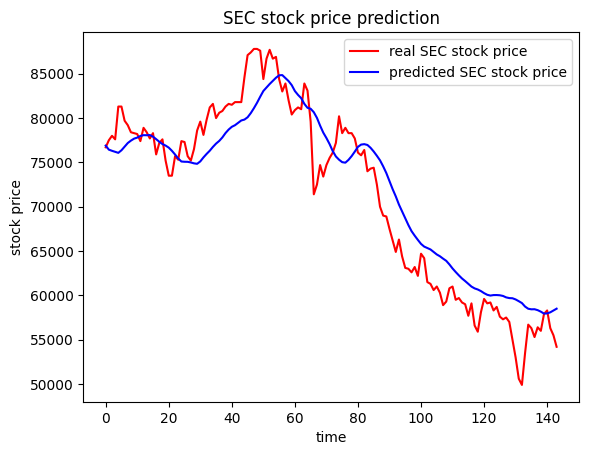

내일 SEC 주가 : [108385.32959805] KRW


C:\Users\82108\AppData\Local\Temp\ipykernel_19436\2429689874.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("내일 SEC 주가 :", df.Close[-1] * y_pred[-1] / df_y.Close[-1], 'KRW')


In [123]:
plt.figure()
plt.plot(rescaled_actual, color='red', label='real SEC stock price')
plt.plot(rescaled_pred, color='blue', label='predicted SEC stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

print("내일 SEC 주가 :", df.Close[-1] * y_pred[-1] / df_y.Close[-1], 'KRW')